In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns 
import time
import sys

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

In [2]:
import platform                

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus']= False

if platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.style.use('seaborn-darkgrid')
    rc('font', family=font_name)

### 1. 데이터 전처리

In [3]:
df = pd.read_csv('NYC_taxi.csv')

In [4]:
df['zip_code'] = df['zip_code'].astype(str)
df['day'] = df['pickup_hour'].str[:10]
df.drop(['pickup_hour','month','is_weekend'], axis=1, inplace=True)

#### 0,1,2,...로 되어있는 요일을 Mon,Tue,Wed,...로 바꿈

In [5]:
요일 = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
df['weekday'] = [요일[x] for x in df['weekday']]

In [6]:
df

,zip_code,day,weekday,hour,cnt
0,11106,2015-01-01,Thu,0,75
1,10006,2015-01-01,Thu,0,64
2,11201,2015-01-01,Thu,0,169
3,11430,2015-01-01,Thu,0,222
4,10032,2015-01-01,Thu,0,64
...,...,...,...,...,...
87015,11219,2015-01-31,Sat,23,1
87016,10456,2015-01-31,Sat,23,3
87017,11355,2015-01-31,Sat,23,1
87018,11210,2015-01-31,Sat,23,1


#### zip_code별로 일평균 택시 호출 수가 많은 지역 뽑기

In [7]:
df2 = df.groupby(['zip_code'])['cnt'].sum().to_frame()
df2.reset_index(inplace=True)
df2['cnt'] = df2['cnt']/31
df2.rename(columns={'cnt':'avg_cnt'}, inplace=True)
df2.sort_values(by='avg_cnt', axis=0, ascending=False, inplace=True)
df2 = df2.reset_index().drop('index',axis=1)

In [8]:
i = 25

In [9]:
zip_code = df2['zip_code'][:i]

#### 상위 25개의 데이터만 뽑아냄

In [10]:
df3 = pd.merge(df,zip_code,how='inner')
df3

,zip_code,day,weekday,hour,cnt
0,11430,2015-01-01,Thu,0,222
1,11430,2015-01-01,Thu,1,119
2,11430,2015-01-01,Thu,2,10
3,11430,2015-01-01,Thu,3,22
4,11430,2015-01-01,Thu,4,25
...,...,...,...,...,...
18506,10003,2015-01-31,Sat,19,2177
18507,10003,2015-01-31,Sat,20,2114
18508,10003,2015-01-31,Sat,21,2326
18509,10003,2015-01-31,Sat,22,2441


#### zip_code A의 2015-01-xx일 xx시의 데이터가 없는 경우 cnt를 0으로 해서 채워줌
> Question: 데이터가 없다고 해서 cnt가 0이 맞을까..?

In [11]:
for x in zip_code:
    zip_df = df3[df3['zip_code']==x]
    
    if len(zip_df) == 24*31:
        continue
    else:
        for day in set(zip_df['day']):
            zip_df2 = zip_df[zip_df['day']==day]
            
            if len(zip_df2) == 24:
                continue
            else:
                for i in range(0,24):
                    if i not in set(zip_df2['hour']):
                        new_row = {'zip_code' : x,
                                   'day' : day,
                                   'weekday' : str(set(zip_df2['weekday']))[2:-2],
                                   'hour' : i,
                                   'cnt' : 0}
                        df3 = df3.append(new_row, ignore_index=True)

In [12]:
df3.sort_values(by=['zip_code','day'], axis=0, ascending=True, inplace=True)
df3.reset_index(inplace=True)
df3.drop('index',axis=1,inplace=True)

In [13]:
df3

,zip_code,day,weekday,hour,cnt
0,10001,2015-01-01,Thu,0,1221
1,10001,2015-01-01,Thu,1,1151
2,10001,2015-01-01,Thu,2,939
3,10001,2015-01-01,Thu,3,997
4,10001,2015-01-01,Thu,4,794
...,...,...,...,...,...
18595,11430,2015-01-31,Sat,19,440
18596,11430,2015-01-31,Sat,20,461
18597,11430,2015-01-31,Sat,21,349
18598,11430,2015-01-31,Sat,22,398


#### zip_code와 요일을 one hot encoding

In [14]:
oh_feature_df = pd.get_dummies(df3, columns = ['zip_code','weekday'])
oh_feature_df

,day,hour,cnt,zip_code_10001,zip_code_10002,zip_code_10003,zip_code_10009,zip_code_10010,zip_code_10011,zip_code_10012,...,zip_code_10128,zip_code_11371,zip_code_11430,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
0,2015-01-01,0,1221,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2015-01-01,1,1151,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2015-01-01,2,939,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2015-01-01,3,997,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2015-01-01,4,794,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18595,2015-01-31,19,440,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
18596,2015-01-31,20,461,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
18597,2015-01-31,21,349,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
18598,2015-01-31,22,398,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


### 2. 데이터 분리

#### 1~24일 데이터(train set)로 마지막 1주일치(test set) cnt 값 예측하기
* 단, 26일과 27일은 test set에서 제외

In [15]:
def split_train_and_test(df, date):
    train_df = df[df['day'] <= date]
    test_df = df[(df['day'] > date) &
                 (df['day']!='2015-01-26') &
                 (df['day']!='2015-01-27')]
    return train_df, test_df

train_df, test_df = split_train_and_test(oh_feature_df, '2015-01-24')

In [16]:
# del train_df['zip_code']
# del test_df['zip_code']
del train_df['day']
del test_df['day']
# del train_df['weekday']
# del test_df['weekday']

y_train = train_df.pop('cnt')
X_train = train_df.copy()

y_test = test_df.pop('cnt')
X_test = test_df.copy()

### 3. 모델링

#### 3-1. XGBoost

In [17]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

* training

In [18]:
xgb = XGBRegressor(random_state=42)
t0 = time.time()
xgb.fit(X_train, y_train)
elapsed = time.time()-t0
print("걸린시간은 {:.2f}초입니다.".format(elapsed))

걸린시간은 0.46초입니다.


* Feature Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

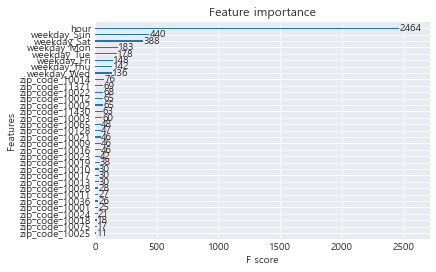

In [19]:
xgboost.plot_importance(xgb)

* Prediction
> Question: 예측값이 음수가 나오는 경우도 있는데, 최소 예측값을 0으로 해도 괜찮겠지..?

In [20]:
prediction_xgb = xgb.predict(X_test)
prediction_xgb = [pred if pred>=0 else 0 for pred in prediction_xgb]

* Scoring

In [21]:
print('training_r2_score: {}\n'.format(xgb.score(X_train, y_train)))
print('<test_set_score>')
print('explained_variance_score: {}'.format(explained_variance_score(y_test, prediction_xgb)))
print('mean_absolute_errors: {}'.format(mean_absolute_error(y_test, prediction_xgb)))
print('mean_squared_errors: {}'.format(mean_squared_error(y_test, prediction_xgb)))
print('r2_score: {}'.format(r2_score(y_test, prediction_xgb)))

training_r2_score: 0.9056710008261342

<test_set_score>
explained_variance_score: 0.9314377793062746
mean_absolute_errors: 86.56354693255822
mean_squared_errors: 14100.442717079322
r2_score: 0.9298484335644069


#### 3-2. ADA Boost

In [22]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

* training

In [23]:
base_model = DecisionTreeRegressor(random_state=42)
adab = AdaBoostRegressor(base_estimator=base_model, random_state=42)

t0 = time.time()

adab.fit(X_train, y_train)

elapsed = time.time()-t0
print("걸린시간은 {:.2f}초입니다.".format(elapsed))

걸린시간은 0.86초입니다.


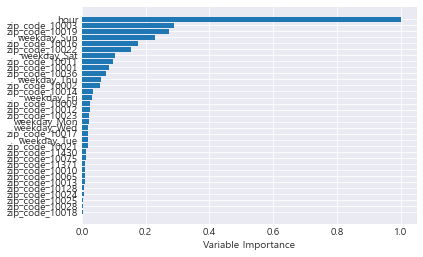

In [24]:
featureImportance = adab.feature_importances_

#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, X_train.columns[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

* predicition

In [25]:
prediction_adab = adab.predict(X_test)
prediction_adab = [pred if pred>=0 else 0 for pred in prediction_adab]

* scoring

In [26]:
print('training_r2_score: {}\n'.format(adab.score(X_train, y_train)))
print('<test_set_score>')
print('explained_variance_score: {}'.format(explained_variance_score(y_test,prediction_adab)))
print('mean_absolute_errors: {}'.format(mean_absolute_error(y_test, prediction_adab)))
print('mean_squared_errors: {}'.format(mean_squared_error(y_test, prediction_adab)))
print('r2_score: {}'.format(r2_score(y_test, prediction_adab)))

training_r2_score: 0.9019277405337189

<test_set_score>
explained_variance_score: 0.9051565253851044
mean_absolute_errors: 94.46648696720416
mean_squared_errors: 19585.13841564621
r2_score: 0.9025613474496581


#### 3-3. Random Forest

In [27]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plot

* training

In [28]:
rf = RandomForestRegressor(random_state=42)

t0 = time.time()

rf.fit(X_train, y_train)

elapsed = time.time()-t0
print("걸린시간은 {:.2f}초입니다.".format(elapsed))

걸린시간은 3.15초입니다.


* predicition

In [29]:
prediction_rf = rf.predict(X_test)
prediction_rf = [pred if pred>=0 else 0 for pred in prediction_rf]

* Feature Importance

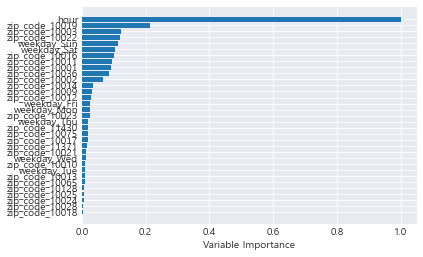

In [30]:
featureImportance = rf.feature_importances_

#가장 높은 중요도 기준으로 스케일링
featureImportance = featureImportance/featureImportance.max()
sorted_idx = np.argsort(featureImportance)
barPos = np.arange(sorted_idx.shape[0])+.5
plt.barh(barPos, featureImportance[sorted_idx], align='center')
plt.yticks(barPos, X_train.columns[sorted_idx])
plt.xlabel('Variable Importance')
plt.show()

* Scoring

In [31]:
print('training_r2_score: {}\n'.format(rf.score(X_train, y_train)))
print('<test_set_score>')
print('explained_variance_score: {}'.format(explained_variance_score(y_test,prediction_rf)))
print('mean_absolute_errors: {}'.format(mean_absolute_error(y_test, prediction_rf)))
print('mean_squared_errors: {}'.format(mean_squared_error(y_test, prediction_rf)))
print('r2_score: {}'.format(r2_score(y_test, prediction_rf)))

training_r2_score: 0.912165426410249

<test_set_score>
explained_variance_score: 0.9370282856214597
mean_absolute_errors: 81.27180360065398
mean_squared_errors: 12990.715947169414
r2_score: 0.9353694709379636


### 4. 모델에 따른 실제값과 예측값 비교 

#### 모델 선택

In [32]:
predictions = {'XGB':prediction_xgb, 'ADAB':prediction_adab, 'RF':prediction_rf}
select = 'RF'

In [33]:
a, b = split_train_and_test(pd.concat([df3[['zip_code','weekday']],oh_feature_df],axis=1), '2015-01-24')
df4 = b.iloc[:,:5]
df4['predict'] = predictions[select]
df4.sort_values(by=['zip_code','day'], axis=0, inplace=True)
df4.reset_index(inplace=True)
df4.drop('index',axis=1,inplace=True)
df4

,zip_code,weekday,day,hour,cnt,predict
0,10001,Sun,2015-01-25,0,1171,1124.278143
1,10001,Sun,2015-01-25,1,1082,1028.757679
2,10001,Sun,2015-01-25,2,938,855.240762
3,10001,Sun,2015-01-25,3,736,710.328675
4,10001,Sun,2015-01-25,4,494,449.663512
...,...,...,...,...,...,...
2995,11430,Sat,2015-01-31,19,440,438.515540
2996,11430,Sat,2015-01-31,20,461,444.005373
2997,11430,Sat,2015-01-31,21,349,485.091168
2998,11430,Sat,2015-01-31,22,398,517.304893


#### 원하는 zip_code의 실제값과 에측값의 그래프 보기

In [34]:
code = 10022

In [35]:
start = 0
for x in df4['zip_code']:
    if x == str(code):
        break
    else:
        start += 1

lenth = len(df4[df4['zip_code']==str(code)])

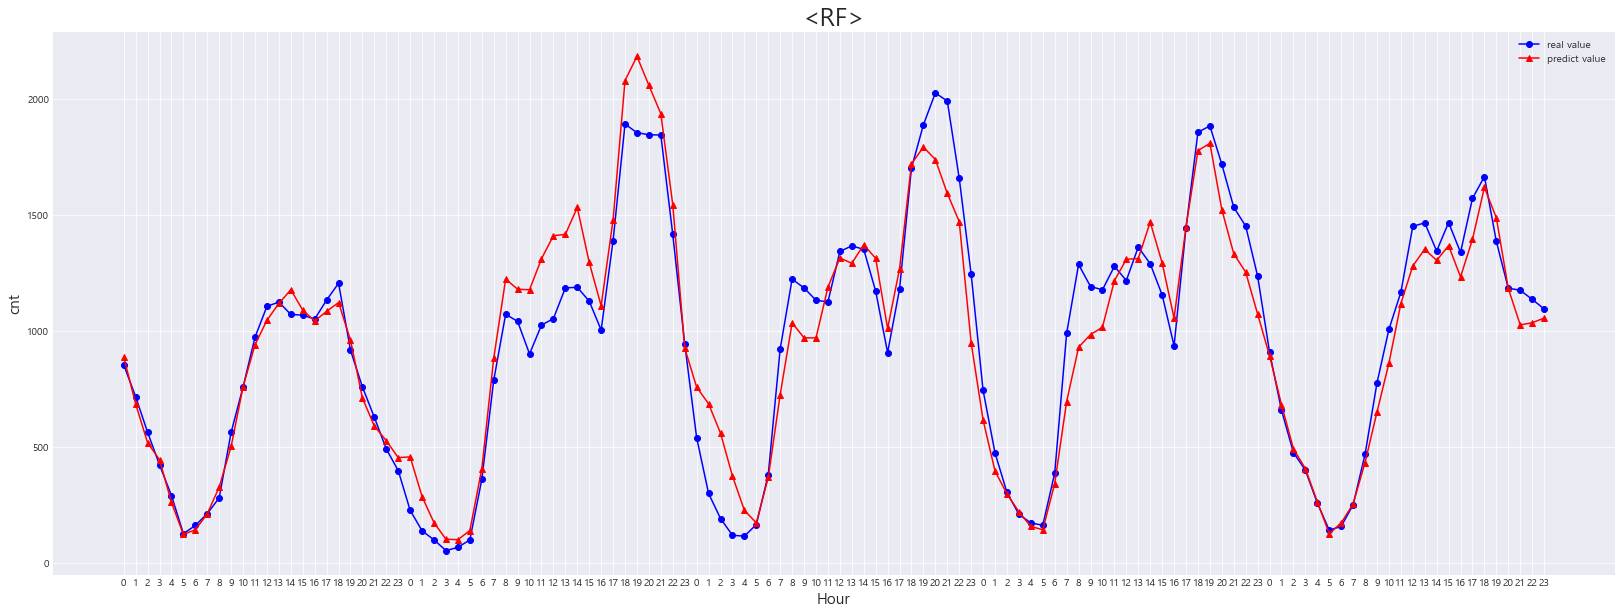

In [36]:
fig = plt.figure(figsize=(28, 10))
chart = fig.add_subplot(1,1,1)
chart.plot(df4['cnt'][start:start+lenth], marker='o', color='blue', label='real value')
chart.plot(df4['predict'][start:start+lenth], marker='^', color='red', label='predict value')
chart.set_title('<{}>'.format(select), fontsize=25)
plt.xticks(df4.index[start:start+lenth], df4['hour'][start:start+lenth])
plt.xlabel('Hour', fontsize=15)
plt.ylabel('cnt', fontsize=15)
plt.legend(loc='best') 

### 5. Checkpoints (Consider more...)

#### Choose Data
* 모델의 데이터는 일평균 cnt가 많은 상위 25개 지역(zip_code)를 사용
* 상위 25개 지역과 전체 지역 데이터의 시각화 결과가 거의 동일하게 나타났기에
* 어차피 목적이 수요가 많은 곳에 공급을 많이 하기 위함 아닌가? 수요가 너무 적은 곳은 신경 별로 안쓸듯

#### Input X variances
* 결국 모델의 입력 변수는 zip_code, 요일, 시간임
* 며칠(1일,2일,3일,...)을 쓰려면 1월만이 아닌 2월, 3월,...의 데이터가 필요할듯
* 마찬가지로 몇월을 쓰려면 15년도만이 이전의 다른 년도 데이터가 필요
* zip_code, 요일, 시간을 묶어본다면 어떨까?  
    * zip_code를 county/borough별로, 요일을 주중/주말로, 시간을 심야/새벽/출근/오전/점심/오후/퇴근/밤 이런 식으로?
    * 이러면 (무슨) 효과가 있을까?
* 기상, 명절, 행사 등 어떤 이벤트가 있는지에 대한 데이터도 있으면 좋을듯
    * 실시간 이벤트에 따른 예측값 변화 모델 가능..?

#### Other useful variances?
* 모델 예측 결과 A지역에 100개 수요 예측된다고 해서 진짜 딱 100개만 공급할거야?
* B지역과 C지역 모두 100개 수요 예측되는데 인력이 부족해. 어느 곳에 더 공급?
* 결국 돈을 더 많이 벌 수 있는 곳, 기사님들의 이동 루트 예상을 통한 효율적인 공급이 필요
    * 이용시간, 지불요금
    * 대기시간
    * 도착지
* 기대값과 확률에 의한 공급량 결정
* 뭔 느낌인지는 알겠는데 좀 막연한 아이디어고, 구체적으로 모델 구현하려면 너무 어렵겠다...ㅎㅎ